In [1]:
import pandas as pd
import numpy as np
import glob
import os
import gc
import json 
base_path = '../input/indoor-location-navigation/'


In [2]:
# pull out all the buildings actually used in the test set, given current method we don't need the other ones
ssubm = pd.read_csv('../input/indoor-location-navigation/sample_submission.csv')

# only 24 of the total buildings are used in the test set, 
# this allows us to greatly reduce the intial size of the dataset

ssubm_df = ssubm["site_path_timestamp"].apply(lambda x: pd.Series(x.split("_")))
used_buildings = sorted(ssubm_df[0].value_counts().index.tolist())

# dictionary used to map the floor codes to the values used in the submission file. 
floor_map = {"B2":-2, "B1":-1, "F1":0, "F2": 1, "F3":2, "F4":3, "F5":4, "F6":5, "F7":6,"F8":7, "F9":8,
             "1F":0, "2F":1, "3F":2, "4F":3, "5F":4, "6F":5, "7F":6, "8F": 7, "9F":8}

In [ ]:
# # get only the wifi bssid that occur over 1000 times(this number can be experimented with)
# # these will be the only ones used when constructing features
# bssid = dict()

# for building in used_buildings:
# #     break
#     folders = sorted(glob.glob(os.path.join(base_path,'train/'+building+'/*')))
#     print(building)
#     wifi = list()
#     for folder in folders:
#         floor = floor_map[folder.split('/')[-1]]
#         files = glob.glob(os.path.join(folder, "*.txt"))
#         for file in files:
#             with open(file) as f:
#                 txt = f.readlines()
#                 for e, line in enumerate(txt):
#                     tmp = line.strip().split()
#                     if tmp[1] == "TYPE_WIFI":
#                         wifi.append(tmp)
#     df = pd.DataFrame(wifi)
#     #top_bssid = df[3].value_counts().iloc[:500].index.tolist()
#     value_counts = df[3].value_counts()
#     top_bssid = value_counts[value_counts >= 0].index.tolist()
#     print(len(top_bssid))
#     bssid[building] = top_bssid
#     del df
#     del wifi
#     gc.collect()

In [3]:
# with open("bssid.json", "w") as f:
#     json.dump(bssid, f)

with open("bssid.json") as f:
    bssid = json.load(f)

In [4]:
import re
def multi_line_spliter(s):
    matches = re.finditer("TYPE_", s)
    matches_positions = [match.start() for match in matches]
    split_idx = [0] + [matches_positions[i]-14 for i in range(1, len(matches_positions))] + [len(s)]
    return [s[split_idx[i]:split_idx[i+1]] for i in range(len(split_idx)-1)]
    
    
def load_df(file):
    #path = str(Path(self.input_path)/f"train/{self.site_id}/{self.floor}/{self.path_id}.txt")
    with open(file) as f:
        data = f.readlines()

#     modified_data = []
#     for s in data:
#         if s.count("TYPE_")>1:
#             lines = multi_line_spliter(s)
#             modified_data.extend(lines)
#         else:
#             modified_data.append(s)
#     del data
#     return modified_data
    return data

In [8]:
from dataclasses import dataclass

import numpy as np


@dataclass
class ReadData:
    acce: np.ndarray
    acce_uncali: np.ndarray
    gyro: np.ndarray
    gyro_uncali: np.ndarray
    magn: np.ndarray
    magn_uncali: np.ndarray
    ahrs: np.ndarray
    wifi: np.ndarray
    ibeacon: np.ndarray
    waypoint: np.ndarray


def read_data_file(data_filename):
    acce = []
    acce_uncali = []
    gyro = []
    gyro_uncali = []
    magn = []
    magn_uncali = []
    ahrs = []
    wifi = []
    ibeacon = []
    waypoint = []

    with open(data_filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line_data in lines:
        line_data = line_data.strip()
        if not line_data or line_data[0] == '#':
            continue

        line_data = line_data.split('\t')

        if line_data[1] == 'TYPE_ACCELEROMETER':
            acce.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ACCELEROMETER_UNCALIBRATED':
            try:
                acce_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4]),\
                               float(line_data[5]), float(line_data[6]), float(line_data[7])])
            except:
                acce_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE':
            gyro.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE_UNCALIBRATED':
            try:
                gyro_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4]),\
                               float(line_data[5]), float(line_data[6]), float(line_data[7])])
            except:   
                gyro_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD':
            magn.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD_UNCALIBRATED':
            try:
                magn_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4]),\
                               float(line_data[5]), float(line_data[6]), float(line_data[7])])
            except:
                magn_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ROTATION_VECTOR':
            ahrs.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_WIFI':
            sys_ts = line_data[0]
            ssid = line_data[2]
            bssid = line_data[3]
            rssi = line_data[4]
            lastseen_ts = line_data[6]
            wifi_data = [sys_ts, ssid, bssid, rssi, lastseen_ts]
            wifi.append(wifi_data)
            continue

        if line_data[1] == 'TYPE_BEACON':
            ts = line_data[0]
            uuid = line_data[2]
            major = line_data[3]
            minor = line_data[4]
            rssi = line_data[6]
            ibeacon_data = [ts, '_'.join([uuid, major, minor]), rssi]
            ibeacon.append(ibeacon_data)
            continue

        if line_data[1] == 'TYPE_WAYPOINT':
            waypoint.append([int(line_data[0]), float(line_data[2]), float(line_data[3])])

    acce = np.array(acce)
    acce_uncali = np.array(acce_uncali)
    gyro = np.array(gyro)
    gyro_uncali = np.array(gyro_uncali)
    magn = np.array(magn)
    magn_uncali = np.array(magn_uncali)
    ahrs = np.array(ahrs)
    wifi = np.array(wifi)
    ibeacon = np.array(ibeacon)
    waypoint = np.array(waypoint)

    return ReadData(acce, acce_uncali, gyro, gyro_uncali, magn, magn_uncali, ahrs, wifi, ibeacon, waypoint)


In [10]:
# generate all the training data 
# used_buildings[:1]
for building in used_buildings:
    #break
    folders = sorted(glob.glob(os.path.join(base_path,'train', building +'/*')))
    dfs = list()
    index = sorted(bssid[building])
    print(building)
    building_df_sensor = []
    #building_df_waypoint = []
    for folder in folders:
        floor = floor_map[folder.split('/')[-1]]
        files = glob.glob(os.path.join(folder, "*.txt"))
        print(floor)
        for file in files:
            data = read_data_file(file)
            if len(data.acce)>0:
                acce_data = pd.DataFrame(data.acce)
                gyro_data = pd.DataFrame(data.gyro)
                magn_data = pd.DataFrame(data.magn)
                ahrs_data = pd.DataFrame(data.ahrs)
                acce_data_un = pd.DataFrame(data.acce_uncali)
                gyro_data_un = pd.DataFrame(data.gyro_uncali)
                magn_data_un = pd.DataFrame(data.magn_uncali)
                
                acce_data.columns = ['ts_sensor','x_acce','y_acce','z_acce']
                gyro_data.columns = ['ts_sensor','x_magne','y_magne','z_magne']
                magn_data.columns = ['ts_sensor','x_gyros','y_gyros','z_gyros']
                ahrs_data.columns = ['ts_sensor','x_rotate','y_rotate','z_rotate']
                try:
                    acce_data_un.columns = ['ts_sensor','x_acce_un','y_acce_un','z_acce_un',\
                                           'x_acce_un2','y_acce_un2','z_acce_un2']
                except:
                    acce_data_un.columns = ['ts_sensor','x_acce_un','y_acce_un','z_acce_un']
                try:
                    gyro_data_un.columns = ['ts_sensor','x_gyros_un','y_gyros_un','z_gyros_un',\
                                       'x_gyros_un2','y_gyros_un2','z_gyros_un2']
                except:
                    gyro_data_un.columns = ['ts_sensor','x_gyros_un','y_gyros_un','z_gyros_un']
                try:
                    magn_data_un.columns = ['ts_sensor','x_magne_un','y_magne_un','z_magne_un',\
                                       'x_magne_un2','y_magne_un2','z_magne_un2'] 
                except:
                    magn_data_un.columns = ['ts_sensor','x_magne_un','y_magne_un','z_magne_un'] 
                    
                
                sensor_data = pd.merge(acce_data,gyro_data,how='left',on='ts_sensor')
                sensor_data = pd.merge(sensor_data,magn_data,how='left',on='ts_sensor')
                sensor_data = pd.merge(sensor_data,ahrs_data,how='left',on='ts_sensor')
                sensor_data = pd.merge(sensor_data,acce_data_un,how='left',on='ts_sensor')
                sensor_data = pd.merge(sensor_data,gyro_data_un,how='left',on='ts_sensor')
                sensor_data = pd.merge(sensor_data,magn_data_un,how='left',on='ts_sensor')
                
                sensor_data['path'] = file.split('/')[-1].split('.')[0]
                sensor_data['site'] = file.split('/')[-3]
                sensor_data['floor'] = floor
                sensor_data['floor_ori'] = folder.split('/')[-1]
                
                building_df_sensor.append(sensor_data)          
    building_df_sensor = pd.concat(building_df_sensor).reset_index(drop=True)
    building_df_sensor.to_csv('../input/data_abstract/'+building+"_train_sensor_all.csv")

5a0546857ecc773753327266
-1
0
1
2
3
5c3c44b80379370013e0fd2b
-1
0
1
2
3
4
5d27075f03f801723c2e360f
-1
0
1
2
3
4
5
6
5d27096c03f801723c31e5e0
-1
0
1
2
3
4
5
5d27097f03f801723c320d97
-1
-2
0
1
2
3
4
5d27099f03f801723c32511d
-1
0
1
2
3
5d2709a003f801723c3251bf
0
1
2
3
5d2709b303f801723c327472
0
1
2
3
-1
5d2709bb03f801723c32852c
-1
0
1
2
3
5d2709c303f801723c3299ee
0
1
2
3
4
5
6
7
8
-1
5d2709d403f801723c32bd39
0
1
2
-1
5d2709e003f801723c32d896
-1
0
1
2
3
4
5da138274db8ce0c98bbd3d2
0
1
2
5da1382d4db8ce0c98bbe92e
-1
0
1
2
3
4
5da138314db8ce0c98bbf3a0
-1
-2
0
1
2
5da138364db8ce0c98bc00f1
0
1
2
5da1383b4db8ce0c98bc11ab
0
1
2
5da138754db8ce0c98bca82f
0
1
2
3
5da138764db8ce0c98bcaa46
-1
0
1
2
3
4
5da1389e4db8ce0c98bd0547
-1
-2
0
1
2
3
5da138b74db8ce0c98bd4774
-1
-2
0
1
2
3
4
5da958dd46f8266d0737457b
-1
0
1
2
3
4
5
6
5dbc1d84c1eb61796cf7c010
-1
1
2
3
4
5
6
7
5dc8cea7659e181adb076a3f
-1
0
1
2
3
4
5
6


In [11]:
file.split('/')[-1].split('.')[0]

'5dd0d97d878f3300066c750b'

In [12]:
ssubm_building_g = ssubm_df.groupby(0)
feature_dict = dict()

for gid0, g0 in ssubm_building_g:
    index = sorted(bssid[g0.iloc[0,0]])
    feats = list()
    print(gid0)
    building_df_sensor = []
    for gid,g in g0.groupby(1):

        # get all wifi time locations
        #with open(os.path.join(base_path, 'test/' + g.iloc[0,1] + '.txt')) as f:
            #txt = f.readlines()
        data = read_data_file(os.path.join(base_path, 'test/' + g.iloc[0,1] + '.txt'))
        if len(data.acce)>0:
            acce_data = pd.DataFrame(data.acce)
            gyro_data = pd.DataFrame(data.gyro)
            magn_data = pd.DataFrame(data.magn)
            ahrs_data = pd.DataFrame(data.ahrs)
            acce_data_un = pd.DataFrame(data.acce_uncali)
            gyro_data_un = pd.DataFrame(data.gyro_uncali)
            magn_data_un = pd.DataFrame(data.magn_uncali)
                
            acce_data.columns = ['ts_sensor','x_acce','y_acce','z_acce']
            gyro_data.columns = ['ts_sensor','x_magne','y_magne','z_magne']
            magn_data.columns = ['ts_sensor','x_gyros','y_gyros','z_gyros']
            ahrs_data.columns = ['ts_sensor','x_rotate','y_rotate','z_rotate']
            try:
                acce_data_un.columns = ['ts_sensor','x_acce_un','y_acce_un','z_acce_un',\
                                       'x_acce_un2','y_acce_un2','z_acce_un2']
            except:
                acce_data_un.columns = ['ts_sensor','x_acce_un','y_acce_un','z_acce_un']
            try:
                gyro_data_un.columns = ['ts_sensor','x_gyros_un','y_gyros_un','z_gyros_un',\
                                   'x_gyros_un2','y_gyros_un2','z_gyros_un2']
            except:
                gyro_data_un.columns = ['ts_sensor','x_gyros_un','y_gyros_un','z_gyros_un']
            try:
                magn_data_un.columns = ['ts_sensor','x_magne_un','y_magne_un','z_magne_un',\
                                   'x_magne_un2','y_magne_un2','z_magne_un2'] 
            except:
                magn_data_un.columns = ['ts_sensor','x_magne_un','y_magne_un','z_magne_un'] 

            sensor_data = pd.merge(acce_data,gyro_data,how='left',on='ts_sensor')
            sensor_data = pd.merge(sensor_data,magn_data,how='left',on='ts_sensor')
            sensor_data = pd.merge(sensor_data,ahrs_data,how='left',on='ts_sensor')
            sensor_data = pd.merge(sensor_data,acce_data_un,how='left',on='ts_sensor')
            sensor_data = pd.merge(sensor_data,gyro_data_un,how='left',on='ts_sensor')
            sensor_data = pd.merge(sensor_data,magn_data_un,how='left',on='ts_sensor')
            
            sensor_data['path'] = g.iloc[0,1]
            sensor_data['site'] = gid0
            building_df_sensor.append(sensor_data)            
    building_df_sensor = pd.concat(building_df_sensor).reset_index(drop=True)
    building_df_sensor.to_csv('../input/data_abstract/'+gid0+"_test_sensor_all.csv")
    

5a0546857ecc773753327266
5c3c44b80379370013e0fd2b
5d27075f03f801723c2e360f
5d27096c03f801723c31e5e0
5d27097f03f801723c320d97
5d27099f03f801723c32511d
5d2709a003f801723c3251bf
5d2709b303f801723c327472
5d2709bb03f801723c32852c
5d2709c303f801723c3299ee
5d2709d403f801723c32bd39
5d2709e003f801723c32d896
5da138274db8ce0c98bbd3d2
5da1382d4db8ce0c98bbe92e
5da138314db8ce0c98bbf3a0
5da138364db8ce0c98bc00f1
5da1383b4db8ce0c98bc11ab
5da138754db8ce0c98bca82f
5da138764db8ce0c98bcaa46
5da1389e4db8ce0c98bd0547
5da138b74db8ce0c98bd4774
5da958dd46f8266d0737457b
5dbc1d84c1eb61796cf7c010
5dc8cea7659e181adb076a3f


In [45]:
building_df_wifi

,ts_wifi,ssid,bssid,rssi,ts_wifi_ls,path,site
0,0000000002340,da39a3ee5e6b4b0d3255bfef95601890afd80709,eebf5db207eec2f3e041f92153d789270f346821,-45,1578474544726,046cfa46be49fc10834815c6,5a0546857ecc773753327266
1,0000000002340,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,7805f319f3f591986effe78c5b41143180278f2d,-46,1578474565732,046cfa46be49fc10834815c6,5a0546857ecc773753327266
2,0000000002340,ab150ecf6d972b476aeab16317bed6189d9f7cce,323607d8444900d64151ee06d164738ac727bbce,-46,1578474564279,046cfa46be49fc10834815c6,5a0546857ecc773753327266
3,0000000002340,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b26914599f6d9ba16b43975394e1eeb9d82f4bab,-47,1578474565725,046cfa46be49fc10834815c6,5a0546857ecc773753327266
4,0000000002340,da39a3ee5e6b4b0d3255bfef95601890afd80709,02a1be3a5dab38320f879489d8a1e0f2a72768b3,-47,1578474547962,046cfa46be49fc10834815c6,5a0546857ecc773753327266
...,...,...,...,...,...,...,...
338901,0000000067545,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,f2fd7c8b3ae74a54ebcd5498b81b513b7c5e564a,-90,1578465380606,ffcd9524c80c0fa5bb859eaf,5a0546857ecc773753327266
338902,0000000067545,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,94887049b5d6072ffd22a5e7de70523931861c2b,-91,1578465380654,ffcd9524c80c0fa5bb859eaf,5a0546857ecc773753327266
338903,0000000067545,b7e6027447eb1f81327d66cfd3adbe557aabf26c,e9f5c01efe9058d460ed3830b2a23b729dea930a,-92,1578465380607,ffcd9524c80c0fa5bb859eaf,5a0546857ecc773753327266
338904,0000000067545,02eb66d35bce69814f108c2f876e600a78ace137,0f5daed11a61e0d6941a1a42ff428ca216d61003,-93,1578465370203,ffcd9524c80c0fa5bb859eaf,5a0546857ecc773753327266


In [46]:
data_waypoint = pd.read_csv('../input/data_abstract/'+"5a0546857ecc773753327266_train_waypoint.csv")


In [47]:
data_waypoint.head()

,Unnamed: 0,ts_waypoint,x,y,path,site,floor,floor_ori
0,0,1.578463e+12,230.03738,153.49635,5e15730aa280850006f3d005,5a0546857ecc773753327266,-1,B1
1,1,1.578463e+12,231.40290,158.41515,5e15730aa280850006f3d005,5a0546857ecc773753327266,-1,B1
2,2,1.578463e+12,232.46200,164.41673,5e15730aa280850006f3d005,5a0546857ecc773753327266,-1,B1
3,3,1.578463e+12,233.94418,171.41417,5e15730aa280850006f3d005,5a0546857ecc773753327266,-1,B1
4,4,1.578464e+12,198.36833,163.52063,5e15730b1506f2000638fc29,5a0546857ecc773753327266,-1,B1


In [60]:
data_waypoint.floor_ori.value_counts()

F1    614
F2    581
B1    525
F4    475
F3    296
Name: floor_ori, dtype: int64

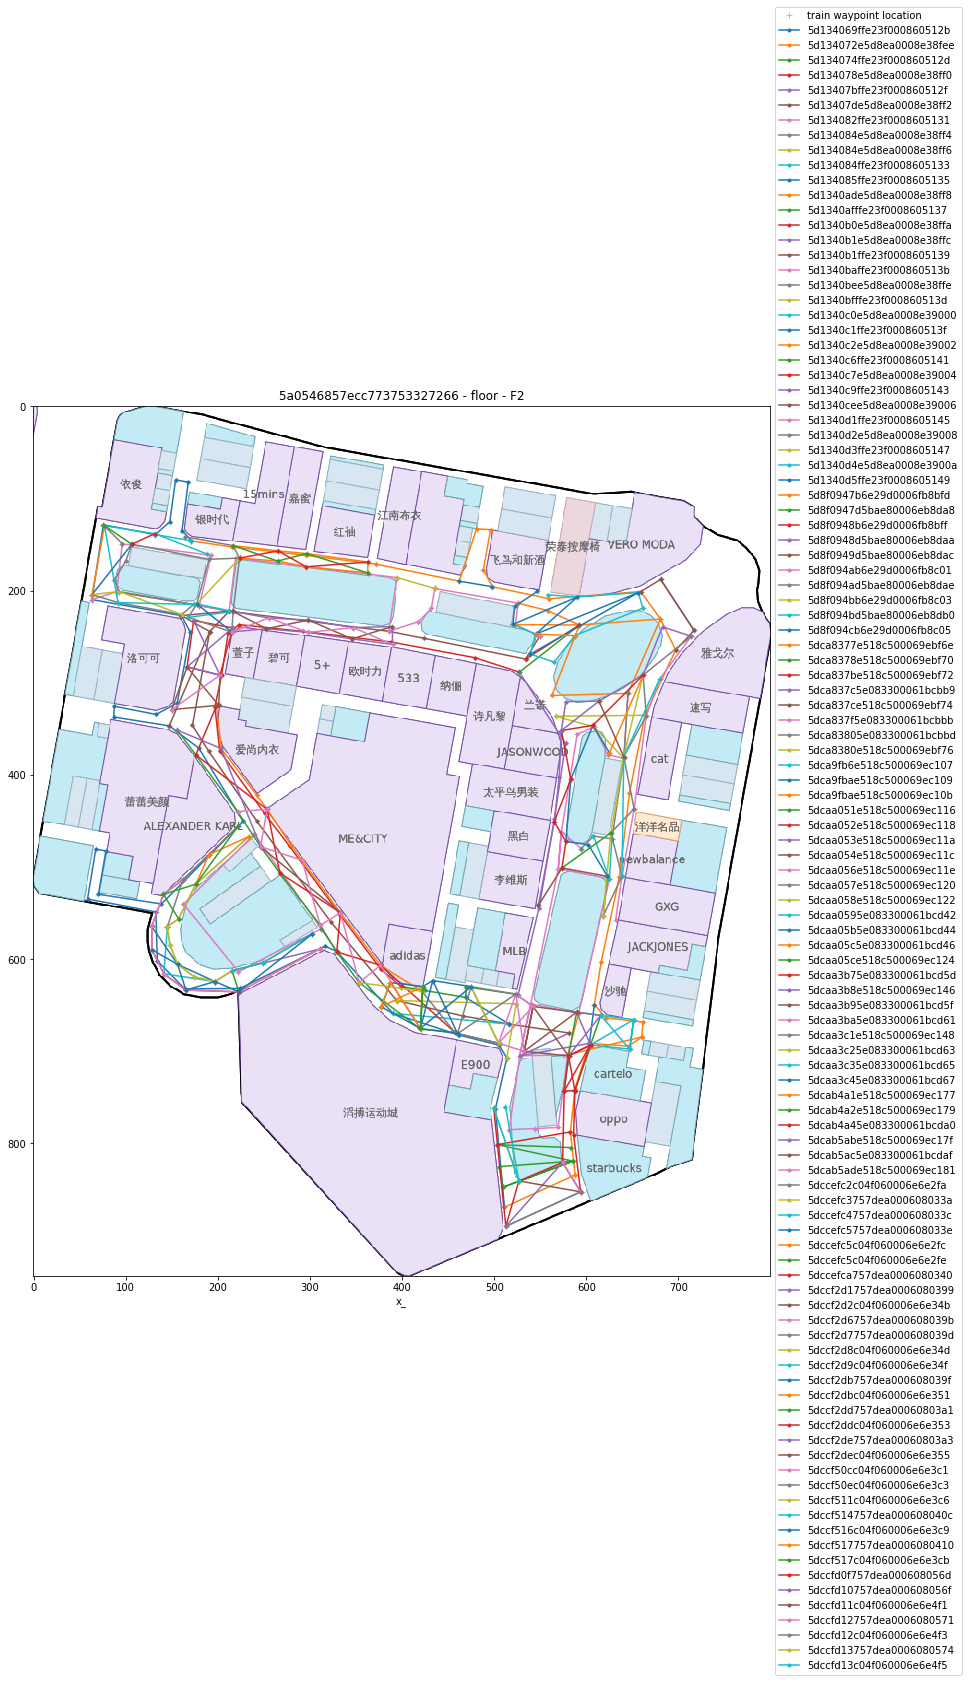

In [78]:

# Helper Functions
import pandas as pd
import numpy as np

import json
import matplotlib.pylab as plt

base="../input/indoor-location-navigation"    
site = "5a0546857ecc773753327266"
map_floor = 'F2'
floor_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_image.png"
json_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_info.json"
with open(json_plan_filename) as json_file:
    json_data = json.load(json_file)

width_meter = json_data["map_info"]["width"]
height_meter = json_data["map_info"]["height"]


floor_img = plt.imread(f"{base}/metadata/{site}/{map_floor}/floor_image.png")

fig, ax = plt.subplots(figsize=(16, 16))
plt.imshow(floor_img)

if 1:#show_train:
    true_locs = data_waypoint.query('site == @site and floor_ori == @map_floor').copy()
    true_locs["x_"] = true_locs["x"] * floor_img.shape[0] / height_meter
    true_locs["y_"] = (
        true_locs["y"] * -1 * floor_img.shape[1] / width_meter
    ) + floor_img.shape[0]
    true_locs.query("site == @site and floor_ori == @map_floor").groupby("path").plot(
        x="x_",
        y="y_",
        style="+",
        ax=ax,
        label="train waypoint location",
        color="grey",
        alpha=0.5,
    )
if 1:#show_preds:
    sub = data_waypoint.query('site == @site and floor_ori == @map_floor').copy()
    sub["x_"] = sub["x"] * floor_img.shape[0] / height_meter
    sub["y_"] = (
        sub["y"] * -1 * floor_img.shape[1] / width_meter
    ) + floor_img.shape[0]
    for path, path_data in sub.query(
        "site == @site and floor_ori == @map_floor"
    ).groupby("path"):
        path_data.plot(
            x="x_",
            y="y_",
            style=".-",
            ax=ax,
            title=f"{site} - floor - {map_floor}",
            alpha=1,
            label=path,
        )
if 1:#fix_labels:
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(
        by_label.values(), by_label.keys(), loc="center left", bbox_to_anchor=(1, 0.5)
    )

In [19]:
data_wifi = pd.read_csv('../input/data_abstract/'+"5a0546857ecc773753327266_train_wifi.csv")
data_waypoint = pd.read_csv('../input/data_abstract/'+"5a0546857ecc773753327266_train_waypoint.csv")
data_wifi.head()

,Unnamed: 0,ts_wifi,ssid,bssid,rssi,ts_wifi_ls,path,site,floor,floor_ori
0,0,1578462618826,da39a3ee5e6b4b0d3255bfef95601890afd80709,c08ad78a45798cfe176a42b35c7381ae602711c5,-46,1578462603277,5e15730aa280850006f3d005,5a0546857ecc773753327266,-1,B1
1,1,1578462618826,7182afc4e5c212133d5d7d76eb3df6c24618302b,4d89139ca69acc0a8a762672a822411a769ac266,-49,1578462618272,5e15730aa280850006f3d005,5a0546857ecc773753327266,-1,B1
2,2,1578462618826,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,30f85a5e14351468a6dd13718a9da3b0d7b73685,-49,1578462618268,5e15730aa280850006f3d005,5a0546857ecc773753327266,-1,B1
3,3,1578462618826,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,fd0bdf5a4dca2566935b14a78c441846b4fbda57,-49,1578462618270,5e15730aa280850006f3d005,5a0546857ecc773753327266,-1,B1
4,4,1578462618826,b7e6027447eb1f81327d66cfd3adbe557aabf26c,bce435ee12b29ad4d543e1418e48fbdea5dfcce2,-49,1578462618271,5e15730aa280850006f3d005,5a0546857ecc773753327266,-1,B1


In [20]:
data_waypoint.head()

,Unnamed: 0,ts_waypoint,x,y,path,site,floor,floor_ori
0,0,1.578463e+12,230.03738,153.49635,5e15730aa280850006f3d005,5a0546857ecc773753327266,-1,B1
1,1,1.578463e+12,231.40290,158.41515,5e15730aa280850006f3d005,5a0546857ecc773753327266,-1,B1
2,2,1.578463e+12,232.46200,164.41673,5e15730aa280850006f3d005,5a0546857ecc773753327266,-1,B1
3,3,1.578463e+12,233.94418,171.41417,5e15730aa280850006f3d005,5a0546857ecc773753327266,-1,B1
4,4,1.578464e+12,198.36833,163.52063,5e15730b1506f2000638fc29,5a0546857ecc773753327266,-1,B1


In [23]:
import scipy.stats as stats
data_fix = []
for path, tmp in data_wifi.groupby('path'):
    tmp = tmp.reset_index(drop=True)
    ts_point_min = data_waypoint[data_waypoint.path==path].ts_waypoint.min()
    ts_point_max = data_waypoint[data_waypoint.path==path].ts_waypoint.max()
    tmp2 = tmp[['ts_wifi']].drop_duplicates()
    tmp2 = tmp2[(tmp2.ts_wifi<=ts_point_max)&(tmp2.ts_wifi>=ts_point_min)]
    if len(tmp2)>0:
        T_rel = data_waypoint[data_waypoint.path==path]['ts_waypoint']
        T_ref = tmp2['ts_wifi']
        xy_hat = scipy.interpolate.interp1d(T_rel, data_waypoint[data_waypoint.path==path][['x','y']], axis=0)(T_ref)
        tmp2['x'] = xy_hat[:,0]
        tmp2['y'] = xy_hat[:,1]
        tmp2['path'] = path
        data_fix.append(tmp2)
data_fix = pd.concat(data_fix).reset_index(drop=True)
print('data fix shape:',data_fix.shape)
data_wifi = pd.merge(data_wifi,data_fix,how='left',on=['ts_wifi','path'])


data fix shape: (8842, 4)


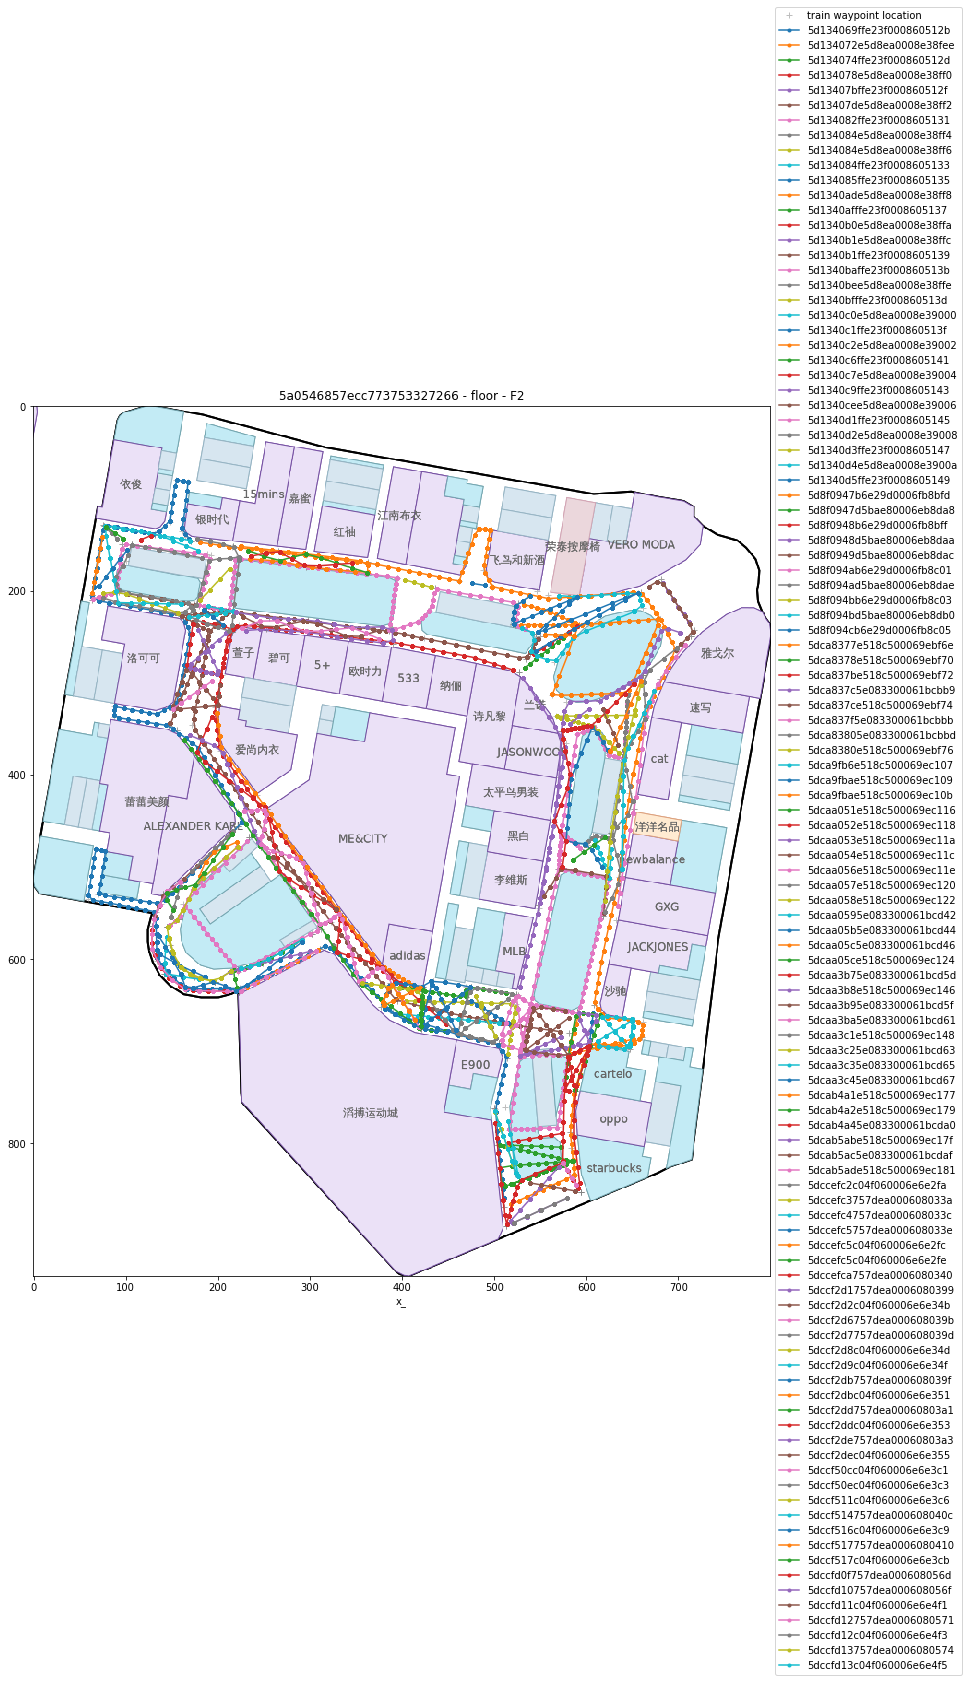

In [36]:

# Helper Functions
import pandas as pd
import numpy as np

import json
import matplotlib.pylab as plt

base="../input/indoor-location-navigation"    
site = "5a0546857ecc773753327266"
map_floor = 'F2'
floor_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_image.png"
json_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_info.json"
with open(json_plan_filename) as json_file:
    json_data = json.load(json_file)

width_meter = json_data["map_info"]["width"]
height_meter = json_data["map_info"]["height"]


floor_img = plt.imread(f"{base}/metadata/{site}/{map_floor}/floor_image.png")

fig, ax = plt.subplots(figsize=(16, 16))
plt.imshow(floor_img)

if 1:#show_train:
    true_locs = data_waypoint.query('site == @site and floor_ori == @map_floor').copy()
    true_locs["x_"] = true_locs["x"] * floor_img.shape[0] / height_meter
    true_locs["y_"] = (
        true_locs["y"] * -1 * floor_img.shape[1] / width_meter
    ) + floor_img.shape[0]
    true_locs.query("site == @site and floor_ori == @map_floor").groupby("path").plot(
        x="x_",
        y="y_",
        style="+",
        ax=ax,
        label="train waypoint location",
        color="grey",
        alpha=0.5,
    )
if 1:#show_preds:
    sub = data_wifi.query('site == @site and floor_ori == @map_floor').copy()
    sub["x_"] = sub["x"] * floor_img.shape[0] / height_meter
    sub["y_"] = (
        sub["y"] * -1 * floor_img.shape[1] / width_meter
    ) + floor_img.shape[0]
    for path, path_data in sub.query(
        "site == @site and floor_ori == @map_floor"
    ).groupby("path"):
        path_data.plot(
            x="x_",
            y="y_",
            style=".-",
            ax=ax,
            title=f"{site} - floor - {map_floor}",
            alpha=1,
            label=path,
        )
if 1:#fix_labels:
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(
        by_label.values(), by_label.keys(), loc="center left", bbox_to_anchor=(1, 0.5)
    )